In [143]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
conn = sqlite3.connect("airbnb_cartagena.sqlite")
df_attributes = pd.read_sql_query("SELECT * FROM Attributes", conn)
df_time_series = pd.read_sql_query("SELECT * FROM TimeSeriesInterpolated", conn)
conn.close()


df_attributes=df_attributes[['Name', 'Host', 'Base fee', 'Cleaning fee', 'URL', 'ID', 'latitude',
       'longitude', 'Property type', 'Person capacity', 'accuracy_rating',
       'checking_rating', 'cleanliness_rating', 'communication_rating',
       'location_rating', 'value_rating', 'satisfaction_rating', 'Reviews',
       'Bedrooms', 'Beds', 'Baths', 'City skyline view', 'Beach view',
       'Sea/Lake view', 'Hot water', 'Jacuzzi', 'Shared pool', 'Shared gym',
       'Patio or balcony', 'Outdoor furniture', 'Outdoor playground',
       'Elevator', 'Carport', 'Dedicated workspace', 'AC', 'Heating', 'TV',
       'Cable TV', 'Wifi', 'Laundry service', 'Kitchen', 'Dining table',
       'Microwave', 'Dishes and silverware', 'Refrigerator', 'Stove',
        'Washer', 'Pets allowed',
     'Crib', 
        'Security cameras', 'Lock on door', 'Keypad']]

#relación de equivalencia función piso*10
df_attributes["Base fee"]=df_attributes["Base fee"].map(lambda x:  min(x//25*25,125) )
df_attributes.head()


,Name,Host,Base fee,Cleaning fee,URL,ID,latitude,longitude,Property type,Person capacity,...,Microwave,Dishes and silverware,Refrigerator,Stove,Washer,Pets allowed,Crib,Security cameras,Lock on door,Keypad
0,14th Floor/Jacuzzi balcony/SeaViews/Parking/King,Alejandra,75.0,38.0,https://www.airbnb.ca/rooms/128289097755583918...,1282890977555839180,10.456400,-75.505410,Entire serviced apartment,5.0,...,0,1,1,1,1,1,0,1,0,0
1,2 BR Modern APT jacuzzi / Rooftop near to beach,Alberto,100.0,35.0,https://www.airbnb.com/rooms/12559080218421979...,1255908021842197930,10.456549,-75.505265,Entire rental unit,6.0,...,0,0,0,0,1,1,0,0,0,0
2,Piso 12/ Jacuzzi/ Vistas/ 1BR/Parqueadero/Pisc...,Alejandra,50.0,36.0,https://www.airbnb.mx/rooms/136437655186096193...,1364376551860961934,10.456523,-75.505361,Entire serviced apartment,4.0,...,1,1,1,0,1,1,1,1,0,0
3,Piso 14/ Jacuzzi/ Vistas/ 2BR/Parqueadero/Pisc...,Alejandra,75.0,36.0,https://www.airbnb.mx/rooms/127921819131081724...,1279218191310817247,10.456398,-75.505406,Entire serviced apartment,5.0,...,1,1,1,1,1,1,0,1,0,0
4,Luxury /Jacuzzi/ Decoration/ Caribbean/ Pools/,Alejandra,75.0,36.0,https://www.airbnb.mx/rooms/125978025681811266...,1259780256818112667,10.456398,-75.505406,Entire serviced apartment,4.0,...,1,1,1,1,1,1,0,1,0,0


In [3]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
columnas_fecha = []
for col in df_time_series.columns:
    try:
        datetime.strptime(col.strip(), "%d/%m/%Y")
        columnas_fecha.append(col)
    except ValueError:
        continue

# 3. Derretir (melt) el DataFrame para convertir columnas de fecha en filas
df_melted = df_time_series.melt(
    id_vars=["ID"],  # columnas fijas (puedes ajustar)
    value_vars=columnas_fecha,
    var_name="Date",
    value_name="Value"
)
df_melted["Date"] = pd.to_datetime(df_melted["Date"])

ids = df_time_series["ID"].unique()[:100]

fig = make_subplots(
    rows=10, cols=10,
    subplot_titles=[f"ID: {i}" for i in ids],
    horizontal_spacing=0.01,
    vertical_spacing=0.03
)

for idx, id_val in enumerate(ids):
    sub = df_melted[df_melted["ID"] == id_val].sort_values("Date")
    
    x = sub["Value"].iloc[:-1].values
    y = sub["Value"].iloc[1:].values
    
    row = idx // 10 + 1
    col = idx % 10 + 1
    
    trace = go.Scatter(
        x=x,
        y=y,
        mode="lines+markers", 
        marker=dict(size=4),
        line=dict(width=1),
        showlegend=False
    )
    
    fig.add_trace(trace, row=row, col=col)

fig.update_layout(
    height=2000,
    width=2000,
    title_text="Value[t+1] vs Value[t] por ID",
    margin=dict(t=40),
)

fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)

for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=10) 

fig.show()



C:\Users\EdsonAlvarez\AppData\Local\Temp\ipykernel_28424\737914486.py:20: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_melted["Date"] = pd.to_datetime(df_melted["Date"])


In [52]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import LinearRegression
from datetime import datetime
import matplotlib.pyplot as plt
import umap
import plotly.express as px
import plotly.colors as pc
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import gudhi as gd

In [172]:

def plot_umap_svd_space(df_space, color_column=None, discrete_colorscale=False):
    """
    Gráfico 3D del espacio embebido (UMAP)
    """
    df_plot = df_space.copy()

    if color_column:
        df_plot = df_plot.merge(df_attributes[['ID', color_column]], on='ID', how='left')
        
        color_values = df_plot[color_column]
    else:
        color_values = None

    fig = px.scatter_3d(
        df_plot,
        x="UMAP1", y="UMAP2", z="UMAP3",
        color=color_values,
        hover_name="ID",
        color_continuous_scale="amp",
        opacity=0.85,
        title="Espacio Embebido (UMAP)",
        template="plotly_dark"
    )
    
    fig.update_layout(
        margin={"r":0, "t":40, "l":0, "b":0},
        paper_bgcolor="#111111",
        plot_bgcolor="#111111",
        font=dict(color="white"),
        scene=dict(
            xaxis=dict(title="UMAP1", backgroundcolor="#111111", gridcolor="gray"),
            yaxis=dict(title="UMAP2", backgroundcolor="#111111", gridcolor="gray"),
            zaxis=dict(title="UMAP3", backgroundcolor="#111111", gridcolor="gray")
        )
    )
    return fig

In [160]:


def plot_rips_complex_3d(df_space, simplex_tree, color_column=None):
    """
    Visualiza en 3D el complejo de Vietoris-Rips (puntos + aristas).
    """
    df_plot = df_space.copy()

    # Extraer coordenadas 3D
    coords = df_plot[["UMAP1", "UMAP2", "UMAP3"]].values
    id_map = dict(zip(df_plot["ID"], range(len(df_plot))))  # ID a índice

    # Color opcional
    if color_column:
        df_plot = df_plot.merge(df_attributes[['ID', color_column]], on='ID', how='left')
        color_values = df_plot[color_column]
    else:
        color_values = None

    # --- Crear trazas de aristas (1-símplices) ---
    edges = []
    for simplex, filtration in simplex_tree.get_skeleton(1):
        if len(simplex) == 2:
            i, j = simplex
            xi, yi, zi = coords[i]
            xj, yj, zj = coords[j]
            edges.append(go.Scatter3d(
                x=[xi, xj, None],  # None para separar segmentos
                y=[yi, yj, None],
                z=[zi, zj, None],
                mode='lines',
                line=dict(color='white', width=1),
                hoverinfo='none',
                showlegend=False
            ))

    # --- Crear traza de puntos ---
    scatter = go.Scatter3d(
        x=df_plot["UMAP1"],
        y=df_plot["UMAP2"],
        z=df_plot["UMAP3"],
        mode='markers',
        marker=dict(
            size=4,
            color=color_values if color_column else 'lightblue',
            opacity=0.8,
            colorbar=dict(title=color_column) if color_column else None
        ),
        text=df_plot["ID"],
        name="Puntos"
    )

    # --- Figura final ---
    fig = go.Figure(data=[scatter] + edges)
    fig.update_layout(
        title="Complejo de Vietoris–Rips en espacio UMAP",
        template="plotly_dark",
        margin=dict(l=0, r=0, b=0, t=40),
        scene=dict(
            xaxis_title="UMAP1",
            yaxis_title="UMAP2",
            zaxis_title="UMAP3",
            xaxis=dict(backgroundcolor="#111111", gridcolor="gray"),
            yaxis=dict(backgroundcolor="#111111", gridcolor="gray"),
            zaxis=dict(backgroundcolor="#111111", gridcolor="gray")
        )
    )
    return fig


In [162]:
def plot_rips_projections(df_space, simplex_tree, color_column=None):
    """
    Muestra proyecciones XY, XZ, YZ del complejo de Rips con subplots.
    """
    df_plot = df_space.copy()
    coords = df_plot[["UMAP1", "UMAP2", "UMAP3"]].values

    # Opcional: colorear por variable
    if color_column:
        df_plot = df_plot.merge(df_attributes[['ID', color_column]], on='ID', how='left')
        color_values = df_plot[color_column]
    else:
        color_values = 'lightblue'

    # Crear figura con 3 subplots
    fig = make_subplots(
        rows=1, cols=3,
        subplot_titles=("UMAP1 vs UMAP2", "UMAP1 vs UMAP3", "UMAP2 vs UMAP3"),
        horizontal_spacing=0.05
    )

    # Aristas (1-símplices)
    def get_edges(dim1, dim2):
        edge_traces = []
        for simplex, _ in simplex_tree.get_skeleton(1):
            if len(simplex) == 2:
                i, j = simplex
                xi, yi = coords[i, dim1], coords[i, dim2]
                xj, yj = coords[j, dim1], coords[j, dim2]
                edge_traces.append(go.Scatter(
                    x=[xi, xj, None], y=[yi, yj, None],
                    mode='lines',
                    line=dict(color='gray', width=1),
                    hoverinfo='none',
                    showlegend=False
                ))
        return edge_traces

    # Nodos (puntos)
    scatter_args = dict(
        mode='markers',
        marker=dict(
            size=4,
            color=color_values,
            showscale=True if color_column else False,
            opacity=0.8,
            colorbar=dict(title=color_column) if color_column else None
        ),
        text=df_plot["ID"],
        hoverinfo='text'
    )

    # --- Subplot 1: XY ---
    for trace in get_edges(0, 1): fig.add_trace(trace, row=1, col=1)
    fig.add_trace(go.Scatter(
        x=df_plot["UMAP1"], y=df_plot["UMAP2"], **scatter_args
    ), row=1, col=1)

    # --- Subplot 2: XZ ---
    for trace in get_edges(0, 2): fig.add_trace(trace, row=1, col=2)
    fig.add_trace(go.Scatter(
        x=df_plot["UMAP1"], y=df_plot["UMAP3"], **scatter_args
    ), row=1, col=2)

    # --- Subplot 3: YZ ---
    for trace in get_edges(1, 2): fig.add_trace(trace, row=1, col=3)
    fig.add_trace(go.Scatter(
        x=df_plot["UMAP2"], y=df_plot["UMAP3"], **scatter_args
    ), row=1, col=3)

    fig.update_layout(
            height=500,
            width=1200,
            title_text="Proyecciones del complejo de Vietoris–Rips (1-símplices)",
            template="plotly_dark",
            margin=dict(l=20, r=20, t=60, b=20),
    )
    return fig


In [147]:



columnas_fecha = []
for col in df_time_series.columns:
    try:
        datetime.strptime(col.strip(), "%d/%m/%Y")
        columnas_fecha.append(col)
    except ValueError:
        continue


df_prices = df_time_series.melt(
    id_vars=["ID"],
    value_vars=columnas_fecha,
    var_name="Date",
    value_name="Value"
)
df_prices["Date"] = pd.to_datetime(df_prices["Date"])
ids_con_nan = df_prices[df_prices["Value"].isna()]["ID"].unique()

df_prices = df_prices[~df_prices["ID"].isin(ids_con_nan)]
df_attributes = df_attributes[~df_attributes["ID"].isin(ids_con_nan)]







df_num = df_attributes.select_dtypes(include=[np.number]).drop(columns=["ID"])

def summarize_prices(df_prices):
    df_prices["log_price"] = np.log1p(df_prices["Value"])
    summary = df_prices.groupby("ID")["log_price"].agg([
        'mean', 'std'
    ]).rename(columns={"mean": "price_mean", "std": "price_std"})

    df_prices['day'] = (df_prices['Date'] - df_prices['Date'].min()).dt.days
    trends = []
    for _, group in df_prices.groupby('ID'):
        X = group['day'].values.reshape(-1, 1)
        y = np.log1p(group['Value'].values)
        slope = LinearRegression().fit(X, y).coef_[0] if len(np.unique(X)) > 1 else 0.0
        trends.append(slope)
    summary['price_trend'] = trends
    return summary

df_price_summary = summarize_prices(df_prices)
df_merged = df_attributes.merge(df_price_summary, left_on="ID", right_index=True)


df_all_num = df_merged.select_dtypes(include=[np.number]).drop(columns=["ID"])
selector = VarianceThreshold(threshold=0.1)
X_var_filtered = selector.fit_transform(df_all_num)
selected_columns = df_all_num.columns[selector.get_support()]
print("Selected_columns:", selected_columns)

df_reduced = pd.DataFrame(X_var_filtered, columns=selected_columns)
corr_matrix = df_reduced.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_corr = [col for col in upper.columns if any(upper[col] > 0.9)] 
df_final_num = df_reduced.drop(columns=to_drop_corr)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_final_num)

umap_model = umap.UMAP(n_components=3, n_neighbors=30, min_dist=0.1, random_state=69)  
X_umap = umap_model.fit_transform(X_scaled)
print(f"UMAP completado")

ids = df_attributes["ID"].values
df_space = pd.DataFrame(X_umap, columns=[f"UMAP{i+1}" for i in range(X_umap.shape[1])], index=ids)

df_space["ID"] = df_space.index

dist_matrix = squareform(pdist(df_space.drop(columns="ID").values, metric='euclidean'))
df_dist = pd.DataFrame(dist_matrix, index=df_space["ID"], columns=df_space["ID"])
print(" Matriz de distancias calculada")


C:\Users\EdsonAlvarez\AppData\Local\Temp\ipykernel_28588\330763948.py:16: UserWarning:

Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.

c:\Users\EdsonAlvarez\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Selected_columns: Index(['Base fee', 'Cleaning fee', 'Person capacity', 'Reviews', 'Bedrooms',
       'Beds', 'Baths', 'City skyline view', 'Beach view', 'Sea/Lake view',
       'Hot water', 'Patio or balcony', 'Outdoor furniture',
       'Outdoor playground', 'Elevator', 'Dedicated workspace', 'Heating',
       'Cable TV', 'Laundry service', 'Dining table', 'Microwave',
       'Dishes and silverware', 'Refrigerator', 'Stove', 'Pets allowed',
       'Crib', 'Security cameras', 'Lock on door'],
      dtype='object')
UMAP completado
 Matriz de distancias calculada


In [148]:
df_attributes['Base fee'].value_counts()


Base fee
75.0     42
100.0    17
50.0     15
125.0     5
Name: count, dtype: int64

In [126]:
import matplotlib.pyplot as plt
import gudhi as gd
import numpy as np
import imageio

plotfiles = []

distance_matrix = df_dist.values
max_lengths = np.linspace(0, 1, 11)  # 8 frames desde 1 a 2.5

for i, max_len in enumerate(max_lengths):
    print(f"Generando frame {i+1} con max_edge_length={max_len:.2f}")
    # Crear complejo Rips
    rips_complex = gd.RipsComplex(distance_matrix=distance_matrix, max_edge_length=max_len)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)

    coords = df_space[["UMAP1", "UMAP2", "UMAP3"]].values

    fig, axs = plt.subplots(1, 3, figsize=(15, 5), facecolor='black')
    for ax in axs:
        ax.set_facecolor('black')
        ax.tick_params(colors='white')  # Ejes blancos
        ax.xaxis.label.set_color('white')
        ax.yaxis.label.set_color('white')
        ax.title.set_color('white')

    def draw_edges(ax, dim1, dim2):
        # Dibujar nervios
        for simplex, _ in simplex_tree.get_skeleton(1):
            if len(simplex) == 2:
                i_, j_ = simplex
                x = [coords[i_, dim1], coords[j_, dim1]]
                y = [coords[i_, dim2], coords[j_, dim2]]
                ax.plot(x, y, color='gray', linewidth=1)
        # Dibujar puntos azul claro
        ax.scatter(coords[:, dim1], coords[:, dim2], c='#add8e6', s=20)
        ax.set_xlabel(f"UMAP{dim1+1}")
        ax.set_ylabel(f"UMAP{dim2+1}")

    draw_edges(axs[0], 0, 1)
    axs[0].set_title("UMAP1 vs UMAP2")

    draw_edges(axs[1], 0, 2)
    axs[1].set_title("UMAP1 vs UMAP3")

    draw_edges(axs[2], 1, 2)
    axs[2].set_title("UMAP2 vs UMAP3")

    plt.suptitle(f"Complejo de Vietoris-Rips (max_edge_length={max_len:.2f})", color='white')
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    filename = f"rips_frame_{i}.png"
    plt.savefig(filename, facecolor='black')
    plotfiles.append(filename)
    plt.close()

# Crear gif
images = [imageio.imread(f) for f in plotfiles]
imageio.mimsave('rips_complex_animation.gif', images, fps=2, loop=0)

print("GIF creado: rips_complex_animation.gif")

Generando frame 1 con max_edge_length=0.00
Generando frame 2 con max_edge_length=0.10
Generando frame 3 con max_edge_length=0.20
Generando frame 4 con max_edge_length=0.30
Generando frame 5 con max_edge_length=0.40
Generando frame 6 con max_edge_length=0.50
Generando frame 7 con max_edge_length=0.60
Generando frame 8 con max_edge_length=0.70
Generando frame 9 con max_edge_length=0.80
Generando frame 10 con max_edge_length=0.90
Generando frame 11 con max_edge_length=1.00


C:\Users\EdsonAlvarez\AppData\Local\Temp\ipykernel_28588\3727957639.py:58: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



GIF creado: rips_complex_animation.gif


In [173]:

fig = plot_umap_svd_space(df_space,color_column="Base fee")
fig.show()


In [158]:
distance_matrix = df_dist.values

rips_complex = gd.RipsComplex(distance_matrix=distance_matrix, max_edge_length=0.6)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)



In [161]:
fig = plot_rips_complex_3d(df_space, simplex_tree,"Base fee")
fig.show()


In [163]:
fig = plot_rips_projections(df_space, simplex_tree,"Base fee")
fig.show()

In [164]:
import gudhi as gd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def persistence_plots_plotly(distance_matrix):
    # Crear complejo de Rips
    max_edge_length=1
    rips_complex = gd.RipsComplex(distance_matrix=distance_matrix, max_edge_length=max_edge_length)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)
    simplex_tree.compute_persistence()
    diag = simplex_tree.persistence()

    # Extraer datos por dimensión
    dims = {}
    for dim, (birth, death) in diag:
        if death == float('inf'):
            death =max_edge_length
        if dim not in dims:
            dims[dim] = []
        dims[dim].append((birth, death))

    # Colores estilo requerido
    color_map = {
        0: "#b41e3c",
        1: "#0f499b",
        2: "#15a852"
    }

    # Crear subplots
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=("Diagrama de persistencia", "BarCode"),
        shared_yaxes=False
    )

    # Diagrama de persistencia (subplot 1)
    for dim, pairs in dims.items():
        births, deaths = zip(*pairs)
        fig.add_trace(
            go.Scatter(
                x=births,
                y=deaths,
                mode='markers',
                name=f"Dim {dim}",
                marker=dict(size=8, opacity=0.85, color=color_map.get(dim, 'gray')),
                legendgroup=f"dim{dim}"
            ),
            row=1, col=1
        )
    # Línea y = x
    fig.add_trace(
        go.Scatter(
            x=[0, max_edge_length],
            y=[0, max_edge_length],
            mode='lines',
            line=dict(dash='dash', color='white'),
            showlegend=False
        ),
        row=1, col=1
    )

    # Código de barras (subplot 2)
    y_offset = 0
    y_labels = []
    for dim, pairs in dims.items():
        color = color_map.get(dim, 'gray')
        for i, (birth, death) in enumerate(pairs):
            y_pos = y_offset + i
            label = f"Dim {dim} - {i}"
            y_labels.append(label)
            fig.add_trace(
                go.Scatter(
                    x=[birth, death],
                    y=[y_pos, y_pos],
                    mode="lines",
                    line=dict(width=4, color=color),
                    name=f"Dim {dim}",
                    legendgroup=f"dim{dim}",
                    showlegend=(i == 0)
                ),
                row=1, col=2
            )
        y_offset += len(pairs)

    # Ejes
    fig.update_xaxes(title_text="Nacimiento", row=1, col=1)
    fig.update_yaxes(title_text="Muerte", row=1, col=1)
    fig.update_xaxes(title_text="Filtración", row=1, col=2)
    fig.update_yaxes(
        title_text="Clases",
        tickmode='array',
        row=1, col=2
    )

    # Layout general
    fig.update_layout(
        title_text="Topología Persistente: Diagrama y Código de Barras",
        width=1100,
        height=600,
        showlegend=True,
        template="plotly_dark"
    )

    return fig

# Mostrar figura
fig = persistence_plots_plotly(df_dist.values)
fig.show()


In [165]:
import numpy as np
import pandas as pd
import gudhi as gd
import plotly.express as px

def betti_evolution(distance_matrix,edge_lengths):
    betti_data = []

    for length in edge_lengths:
        rips_complex = gd.RipsComplex(distance_matrix=distance_matrix, max_edge_length=length)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)
        simplex_tree.compute_persistence()
        bettis = simplex_tree.betti_numbers()
        while len(bettis) < 3:
            bettis.append(0)
        betti_data.append((length, bettis[0], bettis[1], bettis[2]))

    df_betti = pd.DataFrame(betti_data, columns=['edge_length', 'Betti-0', 'Betti-1', 'Betti-2'])
    df_melted = df_betti.melt(id_vars='edge_length', 
                              value_vars=['Betti-0', 'Betti-1', 'Betti-2'],
                              var_name='Betti', 
                              value_name='Count')

    fig = px.line(df_melted, 
                  x='edge_length', 
                  y='Count', 
                  color='Betti',
                  title='Evolución de los Betti numbers',
                  labels={'edge_length': 'max_edge_length', 'Count': 'Número de características'},
                  color_discrete_map={
                      'Betti-0': '#d5274a',
                      'Betti-1': '#d9ff00',
                      'Betti-2': '#08a725'
                  })

    fig.update_layout(
        plot_bgcolor='#111111',
        paper_bgcolor='#111111',
        font_color='white',
        legend_title_text='',
    )

    return fig
edge_lengths = np.linspace(0.1, 1.1, 100)

FIG=betti_evolution(distance_matrix,edge_lengths)
FIG.show()

{75.0: 42, 100.0: 17, 50.0: 15, 125.0: 5}


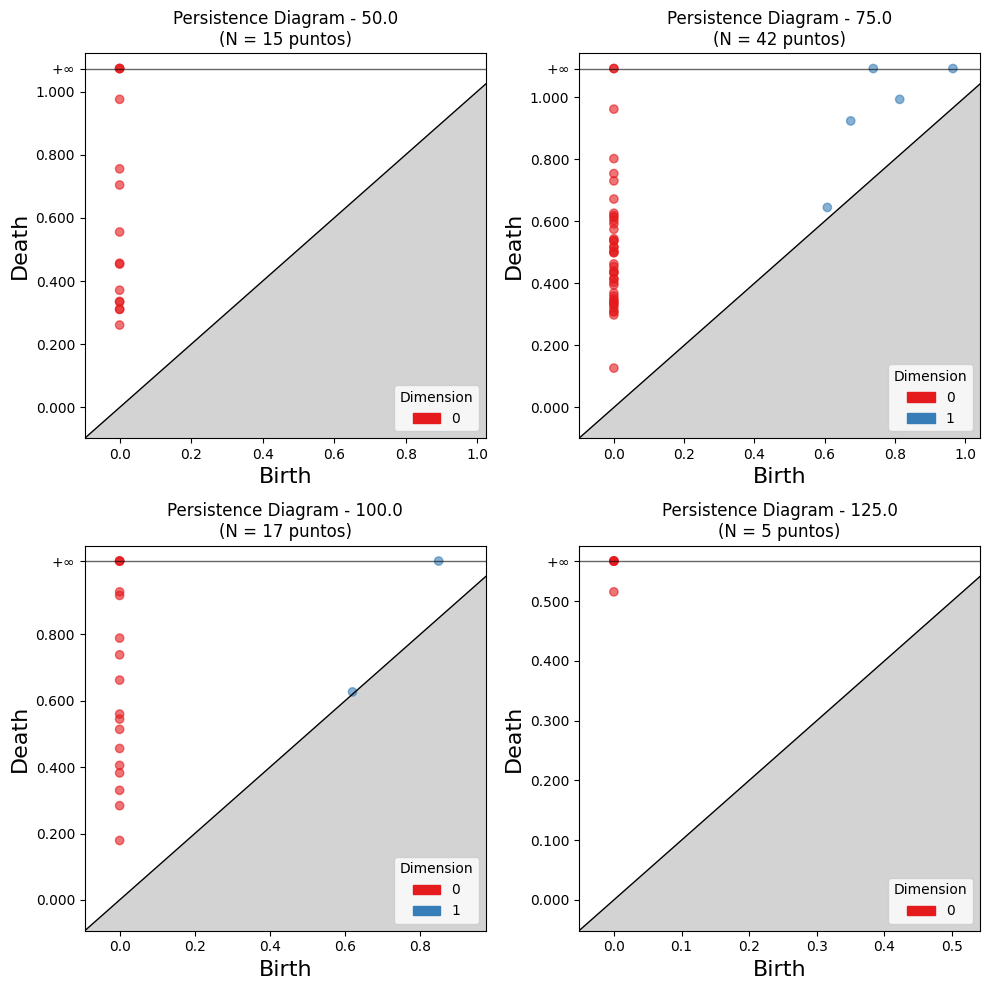

In [170]:
import gudhi as gd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ------------------------------
# 1. Agrupar por Base Fee (5 grupos)
# ------------------------------
df_temp = df_attributes[["ID", "Base fee"]].copy()

# Unir con el espacio
df_merged = df_space.merge(df_temp, on="ID", how="inner")

# Diccionario para guardar diagramas
diagrams_by_group = {}
points_by_group = {}

# ------------------------------
# 2. Calcular diagramas por grupo
# ------------------------------
for group in df_temp["Base fee"].unique():

    df_group = df_merged[df_merged["Base fee"] == group]
    X = df_group[["UMAP1", "UMAP2", "UMAP3"]].values
    points_by_group[group] = len(X)
    

    rips = gd.RipsComplex(points=X, max_edge_length=1)
    simplex_tree = rips.create_simplex_tree(max_dimension=3)
    simplex_tree.compute_persistence()
    
    diagrams_by_group[group] = simplex_tree.persistence()

print(points_by_group)
a = 2  # filas
b = 2  # columnas
fig = plt.figure(figsize=(10, 10))
plt.tight_layout()

for i, group in enumerate(sorted(diagrams_by_group.keys())):
    ax = fig.add_subplot(a, b, i+1)
    gd.plot_persistence_diagram(diagrams_by_group[group], axes=ax)
    ax.set_title(f"Persistence Diagram - {group}\n(N = {points_by_group[group]} puntos)")

plt.tight_layout()
plt.show()


In [185]:
import numpy as np
import pandas as pd

# Inicializar listas para cada feature
sec_longest_b0 = []
thi_longest_b0 = []
sum_b0 = []
mean_b0 = []
onset_longest_b1 = []
length_longest_b1 = []
smallest_onset_b1 = []
average_middle_b1 = []
sum_b1 = []
mean_b1 = []
b1_segment = []
b1_out_segment = []

group_labels = []

# Recorremos cada grupo de 'Base fee'
for group in sorted(diagrams_by_group.keys()):
    dgm = diagrams_by_group[group]
    n_atoms = points_by_group[group]

    # Extraer H0 y H1
    dgm_h0 = [pair for dim, pair in dgm if dim == 0]
    dgm_h1 = [pair for dim, pair in dgm if dim == 1]

    # --- H0 ---
    if len(dgm_h0) > 0:
        dgm_h0 = np.array(dgm_h0)
        lengths_b0 = dgm_h0[:,1] - dgm_h0[:,0]
        lengths_b0 = lengths_b0[lengths_b0 < 10000]  
        lengths_b0_sorted = np.sort(lengths_b0)[::-1]

        sec_longest_b0.append(lengths_b0_sorted[1] if len(lengths_b0_sorted) > 1 else 0)
        thi_longest_b0.append(lengths_b0_sorted[2] if len(lengths_b0_sorted) > 2 else 0)
        sum_b0.append(lengths_b0.sum() if len(lengths_b0) > 0 else 0)
        mean_b0.append(lengths_b0.mean() if len(lengths_b0) > 0 else 0)
    else:
        sec_longest_b0.append(0)
        thi_longest_b0.append(0)
        sum_b0.append(0)
        mean_b0.append(0)

    # --- H1 ---
    if len(dgm_h1) > 0:
        dgm_h1 = np.array(dgm_h1)
        births = dgm_h1[:,0]
        deaths = dgm_h1[:,1]
        valid = ~np.isinf(deaths)

        births = births[valid]
        deaths = deaths[valid]
        lengths = deaths - births
        midpoints = (births + deaths)/2

        onset_longest_b1.append(births[np.argmax(lengths)] if len(lengths) > 0 else 0)
        length_longest_b1.append(lengths.max() if len(lengths) > 0 else 0)
        smallest_onset_b1.append(births.min() if len(births) > 0 else 0)
        average_middle_b1.append(midpoints.mean() if len(midpoints) > 0 else 0)
        sum_b1.append(lengths.sum() if len(lengths) > 0 else 0)
        mean_b1.append(lengths.mean() if len(lengths) > 0 else 0)

        # Contar segmentos en rangos específicos
        in_segment = ((deaths <= 5.5) & (births >= 4.5)).sum()
        out_segment = (((deaths <= 6.5) & (births > 5.5)).sum() +
                       ((deaths < 4.5) & (births >= 3.5)).sum())

        b1_segment.append(in_segment / n_atoms if n_atoms > 0 else 0)
        b1_out_segment.append(out_segment / n_atoms if n_atoms > 0 else 0)
    else:
        onset_longest_b1.append(0)
        length_longest_b1.append(0)
        smallest_onset_b1.append(0)
        average_middle_b1.append(0)
        sum_b1.append(0)
        mean_b1.append(0)
        b1_segment.append(0)
        b1_out_segment.append(0)

    group_labels.append(group)

# Crear DataFrame final con todas las features
df_features = pd.DataFrame({
    "BaseFeeGroup": group_labels,
    "sec_longest_b0": sec_longest_b0,
    "thi_longest_b0": thi_longest_b0,
    "sum_b0": sum_b0,
    "mean_b0": mean_b0,
    "onset_longest_b1": onset_longest_b1,
    "length_longest_b1": length_longest_b1,
    "smallest_onset_b1": smallest_onset_b1,
    "average_middle_b1": average_middle_b1,
    "sum_b1": sum_b1,
    "mean_b1": mean_b1,
    "b1_segment": b1_segment,
    "b1_out_segment": b1_out_segment
})

# Mostrar tabla
print(df_features.head())


   BaseFeeGroup  sec_longest_b0  thi_longest_b0     sum_b0   mean_b0  \
0          50.0        0.755263        0.704129   5.822080  0.485173   
1          75.0        0.801942        0.753720  19.337443  0.483436   
2         100.0        0.917707        0.789157   7.694097  0.549578   
3         125.0        0.000000        0.000000   0.515530  0.515530   

   onset_longest_b1  length_longest_b1  smallest_onset_b1  average_middle_b1  \
0          0.000000           0.000000           0.000000           0.000000   
1          0.674440           0.249018           0.607857           0.776215   
2          0.620164           0.006741           0.620164           0.623535   
3          0.000000           0.000000           0.000000           0.000000   

     sum_b1   mean_b1  b1_segment  b1_out_segment  
0  0.000000  0.000000         0.0             0.0  
1  0.464772  0.154924         0.0             0.0  
2  0.006741  0.006741         0.0             0.0  
3  0.000000  0.000000         

In [182]:

features = [sec_longest_b0, thi_longest_b0, sum_b0, mean_b0, onset_longest_b1, length_longest_b1, smallest_onset_b1, average_middle_b1, sum_b1, mean_b1, b1_segment, b1_out_segment] 
feature_names = ['sec_longest_b0', 'thi_longest_b0', 'sum_b0', 'mean_b0', 'onset_longest_b1', 'length_longest_b1', 'smallest_onset_b1', 'average_middle_b1', 'sum_b1', 'mean_b1', 'b1_segment', 'b1_out_segment'] 

for i in range(len(features)):
    print(feature_names[i])
    df_features[feature_names[i]] = features[i]

sec_longest_b0
thi_longest_b0
sum_b0
mean_b0
onset_longest_b1
length_longest_b1
smallest_onset_b1
average_middle_b1
sum_b1
mean_b1
b1_segment
b1_out_segment


In [186]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

features = [sec_longest_b0, thi_longest_b0, sum_b0, mean_b0, onset_longest_b1, length_longest_b1, smallest_onset_b1, average_middle_b1, sum_b1, mean_b1, b1_segment, b1_out_segment] 
feature_names = ['sec_longest_b0', 'thi_longest_b0', 'sum_b0', 'mean_b0', 'onset_longest_b1', 'length_longest_b1', 'smallest_onset_b1', 'average_middle_b1', 'sum_b1', 'mean_b1', 'b1_segment', 'b1_out_segment'] 

X_train, X_test, y_train, y_test = train_test_split(df_features[feature_names], df_features['BaseFeeGroup'], test_size=0.2)
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
print(np.mean(RF.predict(X_test) == y_test))


0.0


<Axes: >

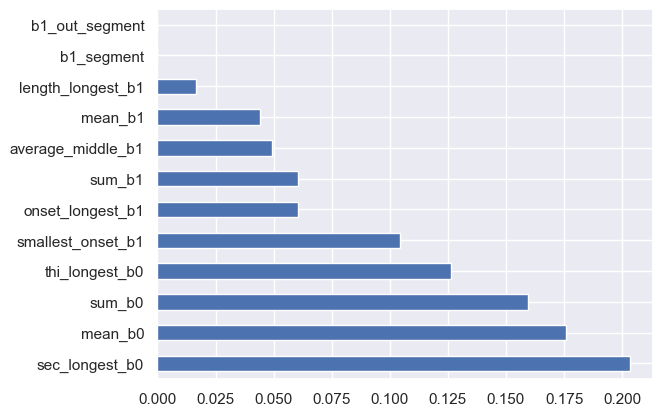

In [187]:
import seaborn as sns
sns.set()
feat_importances = pd.Series(RF.feature_importances_, index=feature_names)
feat_importances.nlargest(len(feature_names)).plot(kind='barh')

In [194]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_pred = RF.predict(X_test)

# Crear matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=RF.classes_)

ValueError: At least one label specified must be in y_true